## Lab # 2
_Tream 5_ <br>
Kozlyak Ruslan, Roman Visotskiy, Egor Shmelev

##### Dataset representation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm import tqdm
import math
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Lasso, LassoLarsIC, BayesianRidge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib
import IPython
from IPython.display import clear_output

In [2]:
base_params_path = '/content/BayesianNetworksParams/'

In [3]:
!pip install -U --no-cache-dir gdown --pre
clear_output()

In [4]:
!gdown -q 1DvOoiMbq0dMT_-1SS-2iOweeu7RPTtfG

!unzip -q /content/BayesianNetworksParams.zip -d  /content/
clear_output()

## We use the following dataset

This document explores a dataset containing prices and attributes for approximately 54,000 round-cut diamonds.
There are 53,940 diamonds in the dataset with 10 features (carat, cut, color, clarity, depth, table, price, x, y, and z). Most variables are numeric in nature, but the variables cut, color, and clarity are ordered factor variables with the following levels.


https://www.kaggle.com/datasets/nancyalaswad90/diamonds-prices

In [63]:
data = pd.read_csv('/content/BayesianNetworksParams/Diamonds Prices2022.csv', index_col=0)

cut_factor = pd.factorize(data['cut'])
data['cut'] = cut_factor[0]

color_factor = pd.factorize(data['color'])
data['color'] = color_factor[0]

color_factor = pd.factorize(data['clarity'])
data['clarity'] = color_factor[0]

At the moment there is one outlier, since he is the only one it is better to delete it

In [64]:
data[data.isna().any(axis=1)]

,carat,cut,color,clarity,depth,table,price,x,y,z


In [65]:
data = data.dropna()
data[data.isna().any(axis=1)]

,carat,cut,color,clarity,depth,table,price,x,y,z


In [66]:
scaler = StandardScaler()
normalized = scaler.fit_transform(data)

data = pd.DataFrame(normalized, columns = data.columns)

In [67]:
data = data.sample(frac = 0.1)
y = data.price
x = data.drop(['price'], axis='columns')

### Here we remove our target variable and reduce the size of dataset beacause of long time fitting models. Moreover we standatized our data due to categoric features.

In [ ]:
x

,carat,cut,color,clarity,depth,table,x,y,z
33686,-0.776243,1.398974,-1.060551,0.987208,-0.872059,0.690414,-0.776628,-0.739455,-0.834281
34243,-0.839535,-0.970782,1.378267,-1.277166,0.733399,-0.652152,-0.892521,-0.905817,-0.820110
1974,0.848250,-0.180863,0.890503,2.119395,-1.011664,0.242892,0.970690,0.906646,0.795369
9715,-1.050508,-0.970782,-0.085024,0.987208,0.314584,-0.204630,-1.311521,-1.264807,-1.245236
15475,0.827152,-0.180863,-0.085024,0.421115,0.593794,-0.652152,0.961775,0.897890,1.007932
...,...,...,...,...,...,...,...,...,...
42045,-0.607465,-0.970782,-1.548314,-1.277166,-2.407714,2.032979,-0.473521,-0.476780,-0.706743
19662,1.502266,0.609056,-0.572787,-0.144979,-0.174033,0.690414,1.362945,1.379463,1.333862
6521,0.679471,1.398974,-0.572787,-1.277166,-2.268109,1.137935,0.979605,1.011716,0.667831
49837,-0.586367,-0.970782,0.402740,0.987208,0.174979,-1.099673,-0.509181,-0.468024,-0.465838


In [72]:
X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(x, y, test_size=0.25, random_state=42)

#Task formulation for regression. Estimation of multiple correlation

Task is to predict price of diamond depending on its characteristics

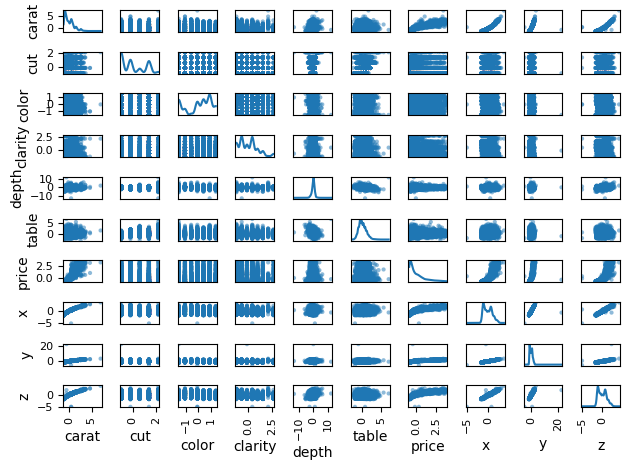

In [ ]:
pd.plotting.scatter_matrix(data, diagonal="kde")
plt.tight_layout()
plt.show()

<Axes: >

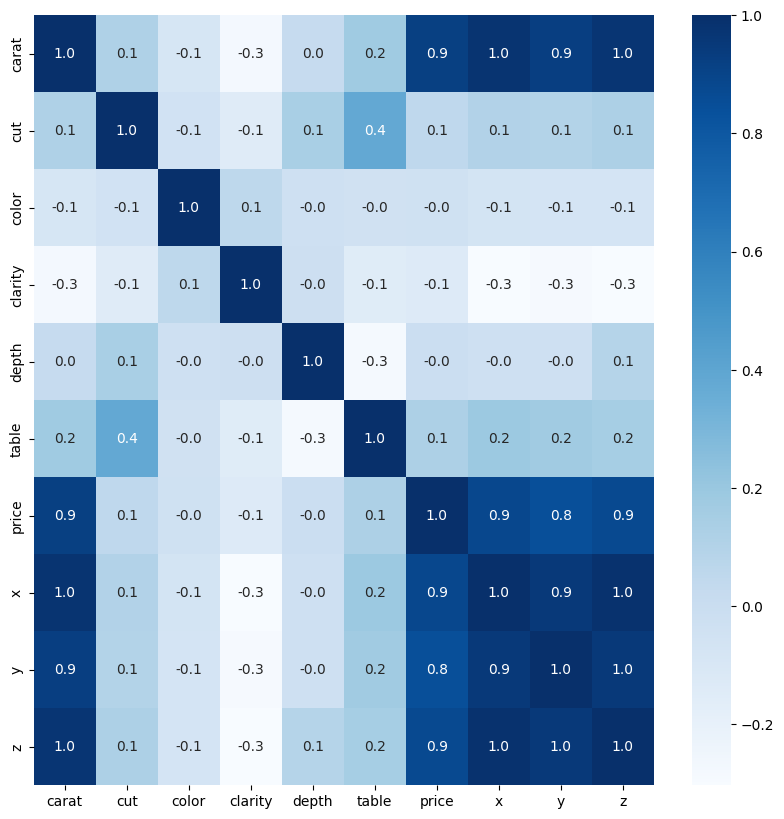

In [ ]:
corr = data.corr()

f, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(corr, annot=True, fmt= '.1f', ax = ax, cmap = 'Blues')

As we can see, the price strongly depends on the carat, as well as the size (x, y, z) of the diamond. Also, in fact, the carat depends on the size, because the larger the diamond, the heavier it is, which means the more carats and more money you could pay.

# Function for confidence interval estimation

In [11]:
def get_conf_int(alpha, lr, X, y):
    coefs = np.r_[[lr.intercept_], lr.coef_]
    X_aux = X.copy()
    X_aux.insert(0, 'const', 1)
    dof = -np.diff(X_aux.shape)[0]
    mse = np.sum((y - lr.predict(X)) ** 2) / dof
    var_params = np.diag(np.linalg.inv(X_aux.T.dot(X_aux)))
    t_val = stats.t.isf(alpha/2, dof)
    gap = t_val * np.sqrt(mse * var_params)

    return pd.DataFrame({
        'lower': coefs - gap, 'upper': coefs + gap, "iterval_width": abs((coefs - gap) - (coefs + gap))
    }, index=X_aux.columns)

In [42]:
import arviz as az
import scipy.stats as st

def get_mode_from_BN(BN, data):
  bn_sample = []
  left_int = []
  right_int = []
  for idx, row in tqdm(data.iterrows()):
    sample = BN.sample(100, evidence=row.to_dict(), progress_bar=False)
    left, right = az.hdi(sample['price'].values, .95)
    left_int.append(left)
    right_int.append(right)
    modes = sample.mode()
    mode = int(modes.iloc[int(modes.shape[0]/2)]['price'])
    # left, right = st.t.interval(0.95, df=len(sample['price'])-1,loc=mode, scale=st.sem(sample['price'])) # remove
    # left_int.append(left) #remove
    # right_int.append(right) #remove
    bn_sample.append(mode)
  return left_int, right_int, bn_sample

In [68]:
def get_metric_dict(r2, mse, mae, mape, model_name):
  return pd.DataFrame({
      'R^2': round(r2, 2),
      'MSE': round(mse, 2),
      'MAE': round(mae, 2),
      'MAPE': round(mape, 2),
  }, index=[model_name])

# Fitting a regression model. Estimation of the confidence interval for the result

# Linear Regression

In [73]:
alpha = 0.05

lin_model = LinearRegression().fit(X_train_1, Y_train_1)

y_pred_lin = lin_model.predict(X_test_1)

linear_intervals = get_conf_int(alpha, lin_model, X_train_1, Y_train_1)

In [74]:
r2 = r2_score(Y_test_1, y_pred_lin)
mae = mean_absolute_error(Y_test_1, y_pred_lin)
mse = mean_squared_error(Y_test_1, y_pred_lin)
mape = mean_absolute_percentage_error(Y_test_1, y_pred_lin)

linear_metrics = get_metric_dict(r2, mse, mae, mape, 'Linear')

# Lasso Regression

In [75]:
alpha = 0.05

lasso_model = Lasso().fit(X_train_1, Y_train_1)

y_pred_lasso = lasso_model.predict(X_test_1)

lasso_intervals = get_conf_int(alpha, lasso_model, X_train_1, Y_train_1)

In [76]:
r2 = r2_score(Y_test_1, y_pred_lasso)
mae = mean_absolute_error(Y_test_1, y_pred_lasso)
mse = mean_squared_error(Y_test_1, y_pred_lasso)
mape = mean_absolute_percentage_error(Y_test_1, y_pred_lasso)


lasso_metrics = get_metric_dict(r2, mse, mae, mape, 'Lasso')

# Polynomial regression

In [77]:
poly = PolynomialFeatures(2)
X_train_new = poly.fit_transform(X_train_1)

poly = PolynomialFeatures(2)
X_test_new = poly.fit_transform(X_test_1)

reg = LinearRegression().fit(X_train_new, Y_train_1)

y_pred_poly = reg.predict(X_test_new)

alpha = 0.05

X_train_new = pd.DataFrame(X_train_new, columns=poly.get_feature_names_out())

polynomial_intervals = get_conf_int(alpha, reg, X_train_new, Y_train_1)

In [78]:
r2 = r2_score(Y_test_1, y_pred_poly)
mae = mean_absolute_error(Y_test_1, y_pred_poly)
mse = mean_squared_error(Y_test_1, y_pred_poly)
mape = mean_absolute_percentage_error(Y_test_1, y_pred_poly)

polynomial_metrics = get_metric_dict(r2, mse, mae, mape, 'Polynomial')

# Fitting a Bayesian regression model. Estimation of probability interval for prediction

In [79]:
alpha = 0.05

bayes = BayesianRidge().fit(X_train_1, Y_train_1)

y_pred_bayes = bayes.predict(X_test_1)

bayes_intervals = get_conf_int(alpha, bayes, X_train_1, Y_train_1)

In [80]:
r2 = r2_score(Y_test_1, y_pred_bayes)
mae = mean_absolute_error(Y_test_1, y_pred_bayes)
mse = mean_squared_error(Y_test_1, y_pred_bayes)
mape = mean_absolute_percentage_error(Y_test_1, y_pred_bayes)

bayes_metrics = get_metric_dict(r2, mse, mae, mape, 'Bayessian')

# Combining results

In [ ]:
pd.concat([linear_metrics, lasso_metrics, polynomial_metrics, bayes_metrics])

,R^2,MSE,MAE,MAPE
Linear,0.83,0.16,0.21,0.66
Lasso,-0.00,0.95,0.74,1.00
Polynomial,0.61,0.37,0.18,0.54
Bayessian,0.84,0.15,0.21,0.66


### According to the R^2 score there are only two quite good models. Nevertheless these models have high MAPE metric.

In [81]:
linear_intervals

,lower,upper,iterval_width
const,-0.006662,0.014925,0.021587
carat,1.218653,1.329115,0.110462
cut,-0.052517,-0.027394,0.025124
color,0.039549,0.061317,0.021768
clarity,0.105512,0.128358,0.022845
depth,-0.030660,0.035039,0.065699
table,-0.037249,-0.010947,0.026302
x,-1.330294,-0.798965,0.531329
y,0.900758,1.447325,0.546567
z,-0.647673,-0.144205,0.503467


In [82]:
lasso_intervals

,lower,upper,iterval_width
const,-0.038627,0.022608,0.061235
carat,-0.156676,0.156676,0.313352
cut,-0.035635,0.035635,0.071270
color,-0.030874,0.030874,0.061749
clarity,-0.032403,0.032403,0.064806
depth,-0.093185,0.093185,0.186369
table,-0.037306,0.037306,0.074612
x,-0.753618,0.753618,1.507235
y,-0.775230,0.775230,1.550459
z,-0.714100,0.714100,1.428199


In [ ]:
polynomial_intervals

,lower,upper,iterval_width
const,NaN,NaN,NaN
1,NaN,NaN,NaN
carat,0.620966,1.296154,0.675187
cut,-0.028221,0.003617,0.031837
color,0.075512,0.094711,0.019199
clarity,0.146161,0.168252,0.022091
depth,-0.059881,0.158778,0.218659
table,-0.036642,-0.009067,0.027575
x,-0.723292,0.338142,1.061434
y,0.114973,1.200758,1.085785


In [83]:
bayes_intervals

,lower,upper,iterval_width
const,-0.006792,0.014796,0.021588
carat,1.215100,1.325567,0.110467
cut,-0.051891,-0.026766,0.025125
color,0.039422,0.061191,0.021769
clarity,0.105777,0.128624,0.022846
depth,-0.033295,0.032407,0.065702
table,-0.038052,-0.011749,0.026303
x,-1.268281,-0.736929,0.531353
y,0.822560,1.369151,0.546591
z,-0.629533,-0.126043,0.503490


# Fitting a Bayesian network

In [8]:
!pip install bamt -q
clear_output()

In [9]:
import pandas as pd
from bamt.networks.hybrid_bn import HybridBN
from sklearn import preprocessing as pp
import bamt.preprocessors as preprocessor
from pgmpy.estimators import K2Score
import seaborn as sns
import os

In [10]:
def save_or_load_model(BN_model, checkpoint_name, data, overwrite = False):
  chekpoint_path = base_params_path + checkpoint_name
  if not os.path.exists(chekpoint_path) or overwrite == True:
    BN_model.fit_parameters(data)
    BN_model.save(chekpoint_path)
  else:
    BN_model.load(chekpoint_path)

In [84]:
data = pd.read_csv('/content/BayesianNetworksParams/Diamonds Prices2022.csv', index_col=0)
data = data.dropna()
data = data.sample(frac = 0.1)

for column in data.select_dtypes(include=["int64", "float64"]).columns.tolist():
  data[column] = data[column].astype(float)

X_train, X_test, Y_train, Y_test = train_test_split(data.drop(['price'], axis = 1), data['price'], test_size=0.25, random_state=42)
train_data = pd.concat([X_train, Y_train], axis = 1)

encoder = pp.LabelEncoder()
discretizer = pp.KBinsDiscretizer(n_bins=10, encode="ordinal", strategy="quantile")
p = preprocessor.Preprocessor([("encoder", encoder), ("discretizer", discretizer)])
discretized_data, est = p.apply(train_data)

In [16]:
discretized_data.head()

,carat,cut,color,clarity,depth,table,x,y,z,price
46857,4,4,2,4,2,4,3,3,3,4
52512,4,3,2,2,6,4,4,4,4,4
48762,4,3,2,4,0,6,4,4,3,4
26732,9,3,3,3,1,5,9,9,9,9
23796,9,3,3,2,6,4,9,9,9,9


In [17]:
p.info

{'types': {'carat': 'cont',
  'cut': 'disc',
  'color': 'disc',
  'clarity': 'disc',
  'depth': 'cont',
  'table': 'cont',
  'x': 'cont',
  'y': 'cont',
  'z': 'cont',
  'price': 'cont'},
 'signs': {'carat': 'pos',
  'depth': 'pos',
  'table': 'pos',
  'x': 'pos',
  'y': 'pos',
  'z': 'pos',
  'price': 'pos'}}

### Here we can see what kind of data type the preprocessing defined our features. Target value defined as continues, it is correct.

# BN with HC optimizer

In [14]:
bn_HC = HybridBN(has_logit=False, use_mixture=False)
bn_HC.add_nodes(p.info)
bn_HC.add_edges(discretized_data)

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [ ]:
file_name = 'Structure_With_HC.html'
bn_HC.plot(file_name)
IPython.display.HTML(filename=file_name)

### As we can see from the result of the network, the carat really depends on the size of the diamond (x, y, z)

In [15]:
bn_HC.fit_parameters(train_data)

In [ ]:
save_or_load_model(bn_HC, 'bn_HC.json', data, overwrite = True)

In [ ]:
bn_HC.get_info()

,name,node_type,data_type,parents,parents_types
0,cut,Discrete,disc,[],[]
1,color,Discrete,disc,[],[]
2,depth,ConditionalGaussian (LinearRegression),cont,[cut],[disc]
3,clarity,Discrete,disc,[cut],[disc]
4,table,ConditionalGaussian (LinearRegression),cont,"[depth, cut]","[cont, disc]"
5,carat,ConditionalGaussian (LinearRegression),cont,"[color, clarity]","[disc, disc]"
6,x,Gaussian (LinearRegression),cont,[carat],[cont]
7,z,Gaussian (LinearRegression),cont,[carat],[cont]
8,price,ConditionalGaussian (LinearRegression),cont,"[carat, clarity]","[cont, disc]"
9,y,Gaussian (LinearRegression),cont,"[carat, x]","[cont, cont]"


In [43]:
bn_sample = get_mode_from_BN(bn_HC, X_test)
clear_output()

# BN with Evo optimizer

In [47]:
!pip install pandas==1.4.1 -q --ignore-installed
clear_output()

In [48]:
bn_EVO = HybridBN(has_logit=False, use_mixture=False)
bn_EVO.add_nodes(p.info)
bn_EVO.add_edges(discretized_data, optimizer='Evo', scoring_function=('K2', K2Score))
clear_output()

In [ ]:
file_name = 'Structure_With_EVO.html'
bn_EVO.plot(file_name)
IPython.display.HTML(filename=file_name)

In [49]:
bn_EVO.fit_parameters(train_data)

In [ ]:
save_or_load_model(bn_EVO, 'bn_EVO.json', data, overwrite = True)

In [ ]:
bn_EVO.get_info()

,name,node_type,data_type,parents,parents_types
0,table,Gaussian (LinearRegression),cont,[],[]
1,z,Gaussian (LinearRegression),cont,[],[]
2,cut,Discrete,disc,[table],[cont]
3,carat,Gaussian (LinearRegression),cont,[z],[cont]
4,color,Discrete,disc,[z],[cont]
5,depth,ConditionalGaussian (LinearRegression),cont,[cut],[disc]
6,x,Gaussian (LinearRegression),cont,[carat],[cont]
7,price,Gaussian (LinearRegression),cont,[carat],[cont]
8,y,Gaussian (LinearRegression),cont,[x],[cont]
9,clarity,Discrete,disc,"[z, price]","[cont, cont]"


In [50]:
bn_evo_sample = get_mode_from_BN(bn_EVO, X_test)

1349it [00:38, 34.88it/s]


# BN with HC optimizer and AIC  scoring_function

In [51]:
bn_HC_AIC = HybridBN(has_logit=False, use_mixture=False)
bn_HC_AIC.add_nodes(p.info)
bn_HC_AIC.add_edges(discretized_data, scoring_function=('AIC', ))
clear_output()

In [ ]:
file_name = 'Structure_With_HC_And_AIC.html'
bn_HC_AIC.plot(file_name)
IPython.display.HTML(filename=file_name)

In [52]:
bn_HC_AIC.fit_parameters(train_data)

In [ ]:
save_or_load_model(bn_HC_AIC, 'bn_HC_AIC.json', data, overwrite = False)

In [ ]:
bn_HC_AIC.get_info()

,name,node_type,data_type,parents,parents_types
0,cut,Discrete,disc,[],[]
1,color,Discrete,disc,[cut],[disc]
2,clarity,Discrete,disc,"[cut, color]","[disc, disc]"
3,table,ConditionalGaussian (LinearRegression),cont,"[cut, color, clarity]","[disc, disc, disc]"
4,depth,ConditionalGaussian (LinearRegression),cont,"[table, color, clarity]","[cont, disc, disc]"
5,y,ConditionalGaussian (LinearRegression),cont,"[table, depth, clarity]","[cont, cont, disc]"
6,x,Gaussian (LinearRegression),cont,"[table, depth, y]","[cont, cont, cont]"
7,carat,Gaussian (LinearRegression),cont,"[depth, y, x]","[cont, cont, cont]"
8,z,Gaussian (LinearRegression),cont,"[depth, x, carat]","[cont, cont, cont]"
9,price,Gaussian (LinearRegression),cont,"[depth, x, carat]","[cont, cont, cont]"


In [53]:
bn_HC_AIC_sample = get_mode_from_BN(bn_HC_AIC, X_test)

1349it [00:38, 35.13it/s]


# BN with HC optimizer and LL  scoring_function

In [54]:
bn_HC_LL = HybridBN(has_logit=False, use_mixture=False)
bn_HC_LL.add_nodes(p.info)
bn_HC_LL.add_edges(discretized_data, scoring_function=('LL',))
clear_output()

In [ ]:
file_name = 'Structure_With_HC_And_LL.html'
bn_HC_LL.plot(file_name)
IPython.display.HTML(filename=file_name)

In [55]:
bn_HC_LL.fit_parameters(train_data)

In [ ]:
save_or_load_model(bn_HC_LL, 'bn_HC_LL.json', data, overwrite = False)

In [ ]:
bn_HC_LL.get_info()

,name,node_type,data_type,parents,parents_types
0,cut,Discrete,disc,[],[]
1,color,Discrete,disc,[cut],[disc]
2,z,ConditionalGaussian (LinearRegression),cont,[cut],[disc]
3,clarity,Discrete,disc,[color],[disc]
4,depth,ConditionalGaussian (LinearRegression),cont,[color],[disc]
5,table,ConditionalGaussian (LinearRegression),cont,[color],[disc]
6,carat,Gaussian (LinearRegression),cont,[depth],[cont]
7,price,Gaussian (LinearRegression),cont,[depth],[cont]
8,x,Gaussian (LinearRegression),cont,[table],[cont]
9,y,Gaussian (LinearRegression),cont,[table],[cont]


In [56]:
bn_HC_LL_sample = get_mode_from_BN(bn_HC_LL, X_test)

1349it [00:40, 33.67it/s]


### Here we can see that x, y, z depends from table. And in fact it is, the larger the table, the larger the size of the diamond

# Sampling и inference of MAP value. Estimation of credible interval for posterior distribution

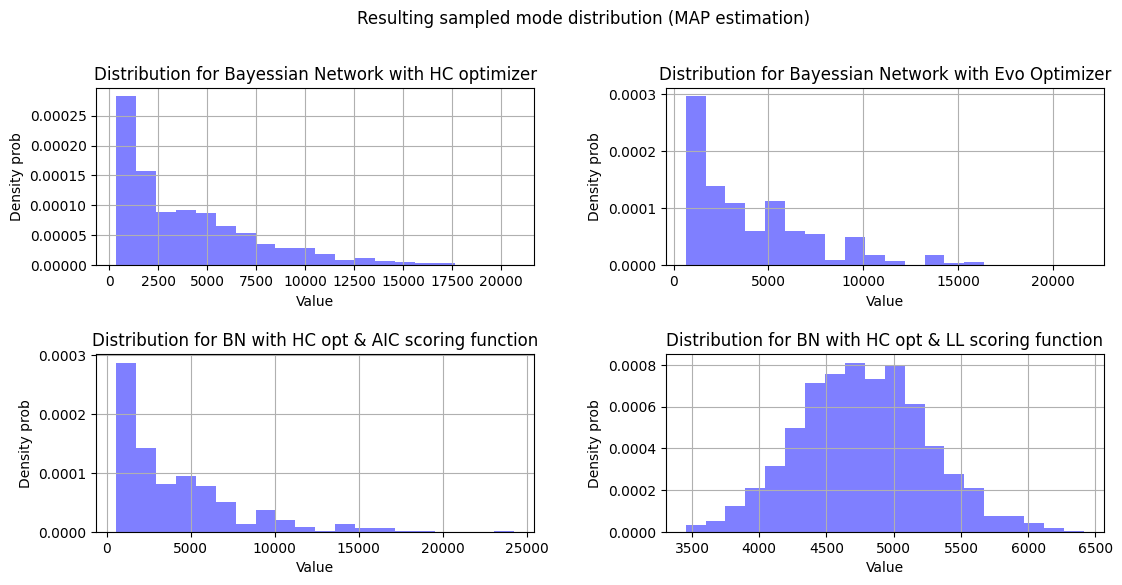

In [ ]:
# unite samples for several Bayessian networks

fig, ((ax_bn, ax_evo), (ax_hc_aic, ax_hc_ll)) = plt.subplots(2, 2, figsize=(13, 6))
fig.suptitle(f'Resulting sampled mode distribution (MAP estimation)')
plt.subplots_adjust(top= 0.85 )
# fig. tight_layout (h_pad=5)
fig.subplots_adjust(wspace=0.3, hspace = 0.5)


ax_bn.hist(bn_sample[2], bins=20, density=True, alpha=0.5, color='b',)
ax_bn.set_title('Distribution for Bayessian Network with HC optimizer')
ax_bn.grid()

ax_evo.hist(bn_evo_sample[2], bins=20, density=True, alpha=0.5, color='b',)
ax_evo.set_title('Distribution for Bayessian Network with Evo Optimizer')
ax_evo.grid()

ax_hc_aic.hist(bn_HC_AIC_sample[2], bins=20, density=True, alpha=0.5, color='b',)
ax_hc_aic.set_title('Distribution for BN with HC opt & AIC scoring function')
ax_hc_aic.grid()

ax_hc_ll.hist(bn_HC_LL_sample[2], bins=20, density=True, alpha=0.5, color='b',)
ax_hc_ll.set_title('Distribution for BN with HC opt & LL scoring function')
ax_hc_ll.grid()


for ax in fig.get_axes():
    ax.set(xlabel='Value', ylabel='Density prob')

### As we can see almost all bayessian networks have the same target mode distribution except network with HC optimizer and LL scoring function. This distribution looks like Normal or Gaussian, wheres other close to Log Normal. Now lets make plot with true and predicted values with confidence intervals.

In [45]:
def plot_confidence_interval_true_pred(Y_test, Y_predicted, lower, upper, name):
  # Visualization
  plt.figure(figsize=(12, 6))

  # Scatter plot for actual vs predicted values

  sns.scatterplot(x=Y_test, y=Y_predicted, alpha=0.6)

  # Ideal Prediction line
  ideal_line = np.linspace(
      min(Y_test.min(), min(Y_predicted)),
      max(Y_test.max(), max(Y_predicted)),
      Y_test.shape[0],
  )
  plt.plot(ideal_line, ideal_line, linestyle="--", color="gray", label="Ideal Prediction")

  # Adding a confidence "interval"

  # plt.errorbar(x=Y_test, y=Y_predicted, yerr=np.array(upper) - np.array(lower), fmt='o', color ='blue', ecolor='orange', label="Confidence interval")
  plt.scatter(Y_test, Y_test - lower, color="orange", alpha=0.3, marker ='v', label="lower bound confidence interval")
  plt.scatter(Y_test, Y_test + upper, color="orange", alpha=0.3, marker = '^', label="upper bound confidence interval")

  # plt.plot(ideal_line, ideal_line - lower, color="orange", alpha=0.3, label="Confidence interval")
  # plt.plot(ideal_line, ideal_line + upper, color="orange", alpha=0.3)


  plt.xlabel("True Values, $")
  plt.ylabel("Predictions, $")
  plt.title(
      f"True vs Predicted by {name} Diamond Prices, MAE = $" +
      str(round(mean_absolute_error(Y_test, Y_predicted)))
  )
  plt.legend()
  plt.grid()
  plt.show()

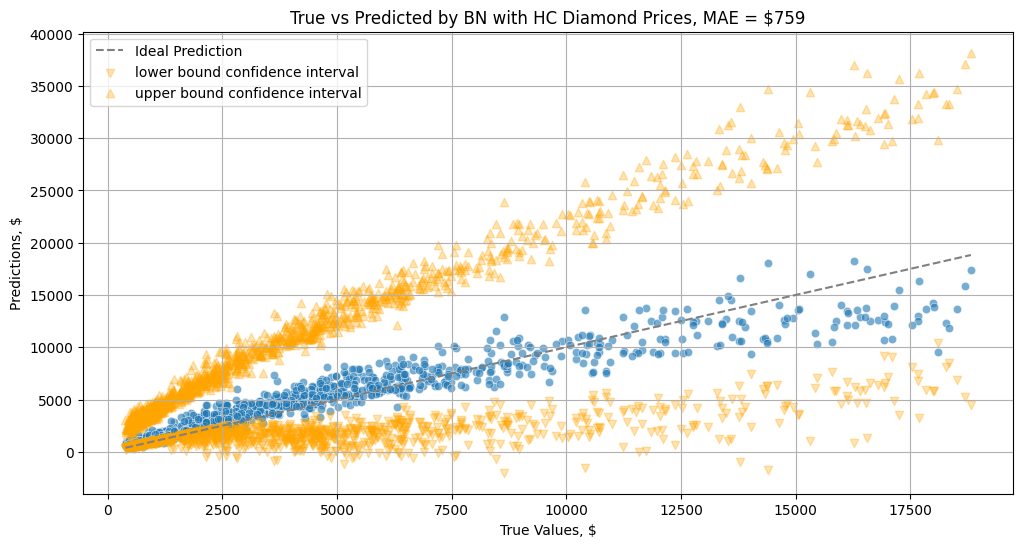

In [57]:
plot_confidence_interval_true_pred(Y_test, bn_sample[2], bn_sample[0], bn_sample[1], 'BN with HC')

### We see that Bayesian Network with HC optimizer almos perfectly predict target value, despite of some deviations all predicted values are in the confidence interval.

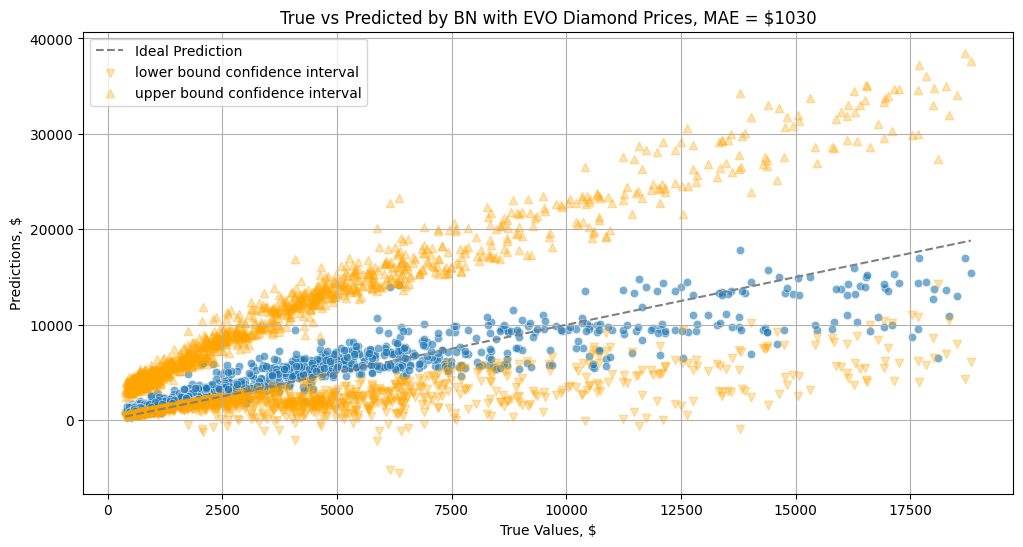

In [58]:
plot_confidence_interval_true_pred(Y_test, bn_evo_sample[2], bn_evo_sample[0], bn_evo_sample[1], 'BN with EVO')

### Looks like previous plot but with more deviations

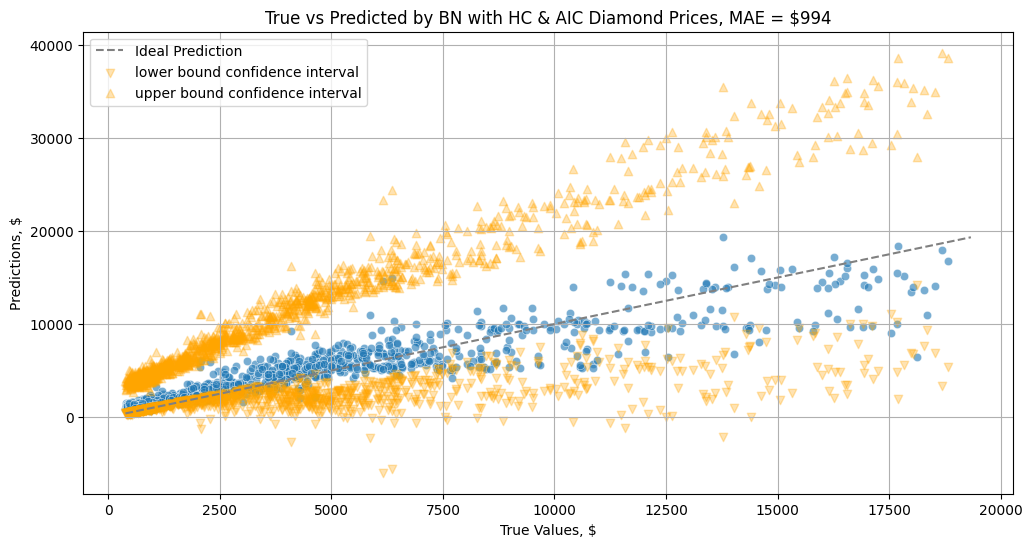

In [59]:
plot_confidence_interval_true_pred(Y_test, bn_HC_AIC_sample[2], bn_HC_AIC_sample[0], bn_HC_AIC_sample[1], 'BN with HC & AIC')

### For each next bayesian networks deviations with ideal predictions are increasing.

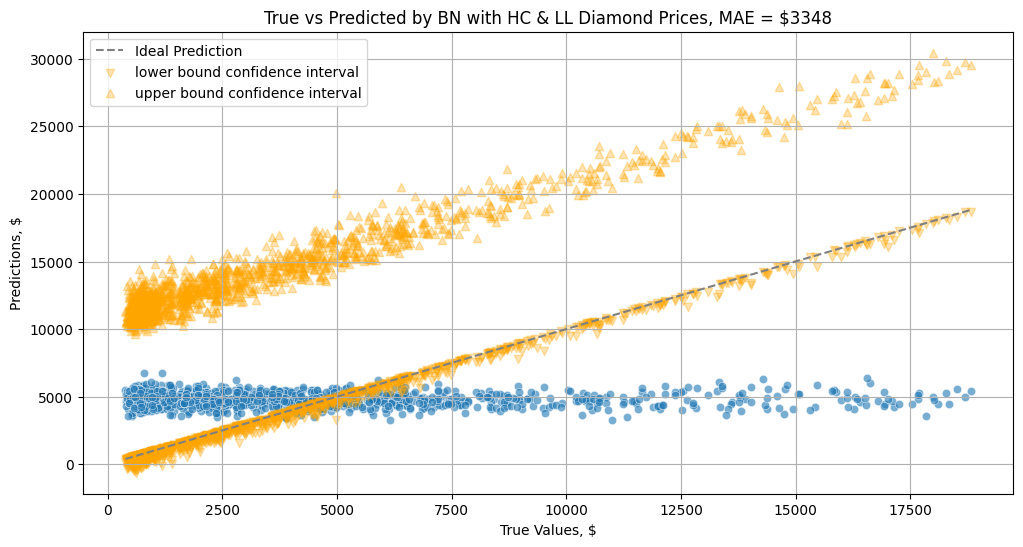

In [60]:
plot_confidence_interval_true_pred(Y_test, bn_HC_LL_sample[2], bn_HC_LL_sample[0], bn_HC_LL_sample[1], 'BN with HC & LL')

### We see that this Bayesian Network couldn't predict less than half of test data. Very strange obtained result

### What about other regressions?

In [61]:
def confidence_interval(y_true, y_predicted, X):
  column_num = X.shape[1]
  alpha = 0.05
  t = stats.t.ppf(1-alpha/2, len(y_true)-column_num)
  residuals = y_true - y_predicted
  s_squared = np.dot(residuals, residuals) / (len(y_true) - column_num)
  std_err = np.array([np.sqrt(np.dot(np.dot(xi, np.linalg.inv(np.dot(X.T.astype(float), X.astype(float)))), xi) * s_squared) for xi in X])
  conf_interval = t * std_err
  return y_predicted - conf_interval, y_predicted + conf_interval

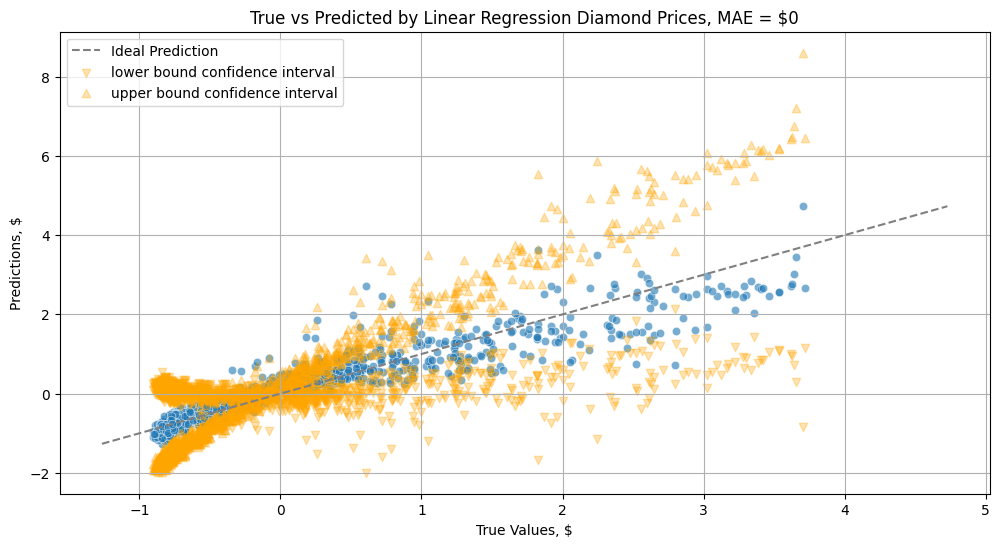

In [85]:
lin_intervals = confidence_interval(Y_test_1, y_pred_lin, X_test_1.values)
plot_confidence_interval_true_pred(Y_test_1, y_pred_lin, lin_intervals[0], lin_intervals[1], 'Linear Regression')

### Almost perfect prediction, nevertheless there are some predictions that are out of the confidence intervals. It is very important to remember that our target feature is standartized for these regressions (Linear, Lasso, Polynomial, Bayesian).

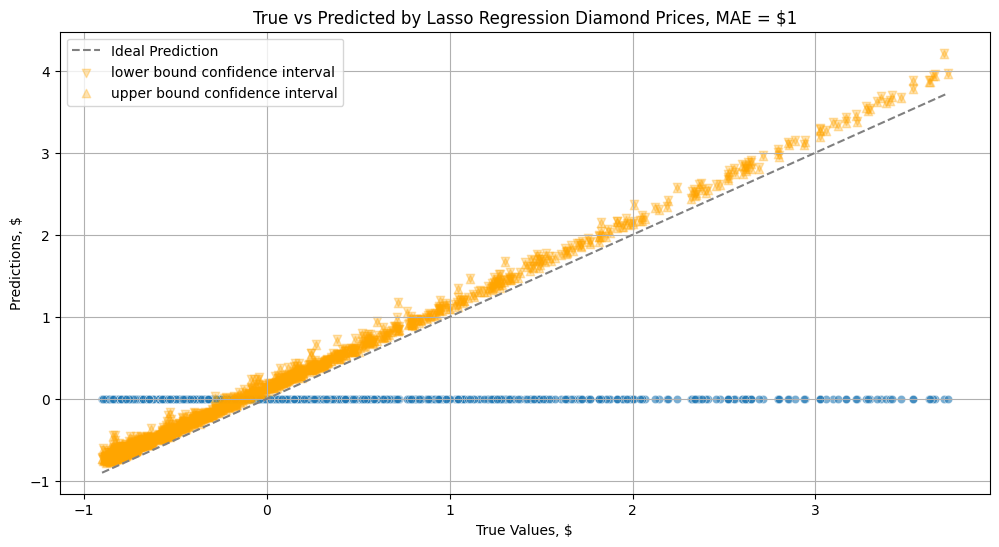

In [86]:
lasso_intervals = confidence_interval(Y_test_1, y_pred_lasso, X_test_1.values)
plot_confidence_interval_true_pred(Y_test_1, y_pred_lasso, lasso_intervals[0], lasso_intervals[1], 'Lasso Regression')

### Another strange predictions like we saw with Bayesian Network.

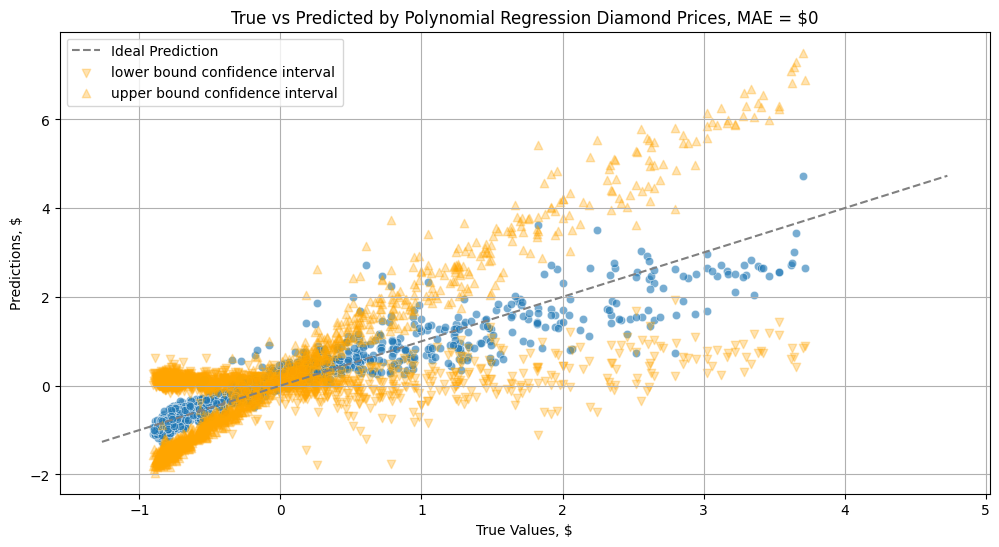

In [87]:
poly_intervals = confidence_interval(Y_test_1, y_pred_poly, X_test_new)
plot_confidence_interval_true_pred(Y_test_1, y_pred_lin, poly_intervals[0], poly_intervals[1], 'Polynomial Regression')

### Obtained polynomial result looks like Linear Regression

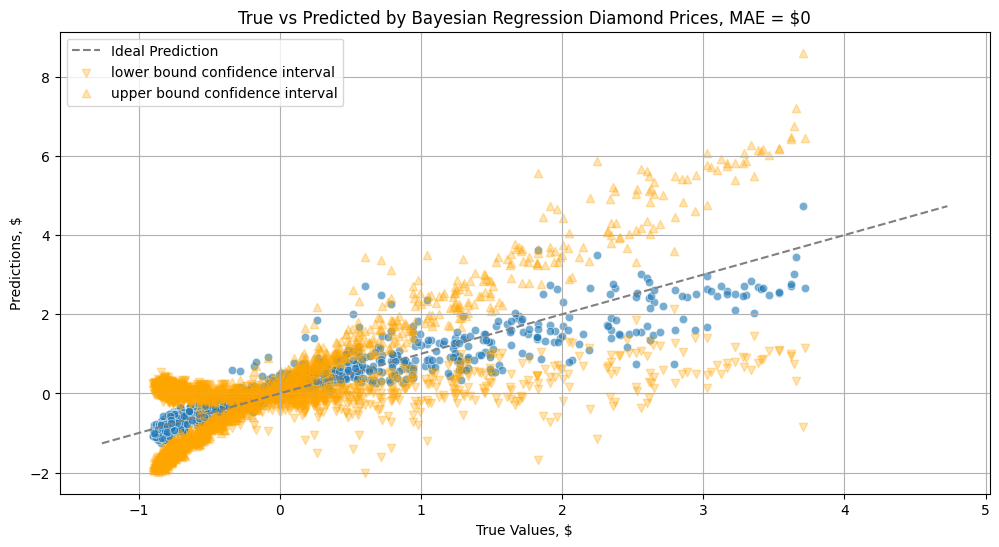

In [88]:
bayes_intervals = confidence_interval(Y_test_1, y_pred_bayes, X_test_1.values)
plot_confidence_interval_true_pred(Y_test_1, y_pred_bayes, bayes_intervals[0], bayes_intervals[1], 'Bayesian Regression')

### Bayesian regression dealt with predictions not bad, however there are a lot of observations that go beyond the confidence intervals.

# Аnalysis and comparison of point estimations of quality and intervals for regression results

### Now let's look at quality metrics to compare models

In [ ]:
metrics_compare = pd.concat([linear_metrics, lasso_metrics, polynomial_metrics, bayes_metrics])

df2 = pd.DataFrame({
'R^2': [r2_score(Y_test, bn_sample[2]), r2_score(Y_test, bn_evo_sample[2]), r2_score(Y_test, bn_HC_AIC_sample[2]),
        r2_score(Y_test, bn_HC_LL_sample[2])],
'MSE': [mean_squared_error(Y_test, bn_sample[2]), mean_squared_error(Y_test, bn_evo_sample[2]),
        mean_squared_error(Y_test, bn_HC_AIC_sample[2]), mean_squared_error(Y_test, bn_HC_LL_sample[2])],
 'MAE': [mean_absolute_error(Y_test, bn_sample[2]), mean_absolute_error(Y_test, bn_evo_sample[2]),
        mean_absolute_error(Y_test, bn_HC_AIC_sample[2]), mean_absolute_error(Y_test, bn_HC_LL_sample[2])],
 'MAPE': [mean_absolute_percentage_error(Y_test, bn_sample[2]), mean_absolute_percentage_error(Y_test, bn_evo_sample[2]),
        mean_absolute_percentage_error(Y_test, bn_HC_AIC_sample[2]), mean_absolute_percentage_error(Y_test, bn_HC_LL_sample[2])]},
  index = ['BN with HC', 'BN with EVO', 'BN with HC & AIC', 'BN with HC & LL'])

metrics_compare = metrics_compare.append(df2)
metrics_compare.round(2)

,R^2,MSE,MAE,MAPE
Linear,0.83,0.16,0.21,0.66
Lasso,-0.00,0.95,0.74,1.00
Polynomial,0.61,0.37,0.18,0.54
Bayessian,0.84,0.15,0.21,0.66
BN with HC,0.92,1141510.45,699.79,0.26
BN with EVO,0.85,2031837.50,982.90,0.44
BN with HC & AIC,0.85,2023683.17,941.24,0.46
BN with HC & LL,-0.10,15346287.99,3222.81,2.39


### So we see that almost all Bayesian Networks have the same R^2 score as Linear and Bayesian regressions. It is strange thing, that Lasso Regression and BN with HC & LL scoring have such a bad result. Unfortunately we cannot compare models MSE due to different type of data (for bayesian network data wasn't be standartized). Mention that the best value for MAPE score is 0.0. To sum up we would like to highlight two regression models - Bayesian Network with HC optimizer and Bayesian regression. The disadvantages of the Bayesian model include, of course, its computational complexity: perhaps you remember how the banal problem of linear regression brought us down into the abyss of calculations, and then it only becomes more difficult. If we want to apply the Bayesian approach to more complex models, for example, neural networks, we will have to resort to simplifications, coarsening, approximations, which, of course, worsens our estimates. But if you forgive him this forced inaccuracy, he is more logical and honest.

### During this work we study different type of regression and estimate their quality scores. For each specific task we should carefully select regression model. For example, Linear regression is very simple and friendly in the explanations, but in complex task and data it would be useful to apply Bayesian Networks or regression. Bayesian Networks good at complex relationships between features e.t.c other bayesian approach could be good with small data size e.t.c. Anyway before applying certain regression it is better to investigate your data instead of choosing model randomly.